# Bar Crawl: 
## Classifying elevated transdermal alcohol concentration (TAC) using phone accelerometer data

Excessive drinking poses risks to an individual's health (e.g. alcohol poisoning or death) as well as personal and public safety (e.g. vehicular accidents). Moreover, inebriation reduces awareness of one's own impairment and hinders judgment to avoid such potentially dangerous behaviors. This analysis aims at providing an intervention to excessive consumption and risky behaviors, predicting when transdermal alcohol concentration (TAC, a proxy for blood alcohol concentration) are above legal limits for driving using observations of subject movement as measured by their mobile phone accelerometer. 

The data used for this analysis is credited to Jackson A Killian (Harvard University), Danielle R Madden (USC), and John Clapp (USC). These data are publicly available at:

> https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking

> https://archive.ics.uci.edu/ml/machine-learning-databases/00515/data.zip (direct link to download)

And the authors initial analyses are detailed in:

> Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42)

To run the following notebook, you will need to download and unzip the data folder to your current working directory.


## Contents of Analysis

 - [Inspect Data and Initial Cleanup](#inspection)
 - [Extract Windowed Samples and Transform Data](#transform)
 - [Create Features](#features)
 - [Fit Models and Assess Performance](#models)

## Results



In [21]:
# Use saved data to run cells from later sections.
# False, all the data prep done from scratch.

USE_SAVED=True

# Setup

Install required packages (requirement.txt) into your working Python environment. Run "make install" in the command line of the working directory.

Packages are imported as needed in the different sections of this analysis. 
I reduce data size (converting data types to smallest suitable) and converting original .csv files into .ftr (feather) using code from github user fujiyuu75 (cited in BarCrawl_helpers). 

In [2]:
from os import listdir, walk, environ
from os.path import isfile, join, exists

import requests
import pickle

from BarCrawl_helpers import *

import numpy as np
import pandas as pd

from scipy.signal import spectrogram
from scipy.interpolate import interp1d

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import re as re
from tqdm import tqdm

import sys
import warnings

warnings.filterwarnings('ignore')

In [3]:
TAC_limit = 0.08

# Cartesian Accelerations and their PCA components (top 2 of 3)
xyz = ['x', 'y', 'z']
C = ['C1', 'C2']

# Spherical Accelerations and their PCA components (top 2 of 3)
rtp = ['rho', 'theta', 'phi']
S = ['S1', 'S2']

# Fetch Data and Initial Inspection

 - get data from Kaggle
 - create data folder
 - reduce memory usage (see citation for borrowed code snippet)
 - convert .csv to .ftr (feather) for faster loading in future runs

<a id='inspection'></a>


## Make Dataframes and Split Accelerometer Data by Subject 

In [4]:
datafolder = 'feather_data'

if not exists('./feather_data'):
    file_list = [os.path.join('data', 'clean_tac', file) for file in os.listdir(os.path.join('data', 'clean_tac')) if file[-3:]=='csv']
    file_list = file_list + [os.path.join('data', 'all_accelerometer_data_pids_13.csv'), os.path.join('data','phone_types.csv')]

    os.mkdir(datafolder)
    [csv2feather(file, datafolder=datafolder) for file in file_list]



In [5]:
acc_datafile = 'all_accelerometer_data_pids_13.ftr'
phone_datafile = 'phone_types.ftr'


all_acc_df = pd.read_feather(join(datafolder, acc_datafile))
phones_df = pd.read_feather(join(datafolder, phone_datafile))

In [6]:
all_acc_df.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [7]:
# make a dictionary of TAC files with keys being subject PIDs
# # pattern = re.compile(r'\D{2}\d{4}')
# pattern = re.compile(r'\D{2}\d{4}')
# tac_files = [filename if re.match(r'\D{2}\d{4}',filename) for filename in listdir(datafolder)].sort()

tac_files = sorted([filename for filename in listdir(datafolder) if re.match(r'\D{2}\d{4}',filename)])
pid_list = [filename[0:6] for filename in tac_files]

tac_df = {}

for tac_file in tac_files:
    pid = tac_file[0:6]
    if tac_file.endswith('.ftr'):
        tac_df[pid] = pd.read_feather(join(datafolder, tac_file))
    elif tac_file.endswith('.csv'):
        tac_df[pid] = pd.read_csv(join(datafolder, tac_file))
    else:
        print('%s is neither a .csv or .ftr' % tac_file)

In [8]:
acc_df = {}

for pid in pid_list:
    acc_df[pid] = all_acc_df[all_acc_df.pid==pid].reset_index().drop(columns = 'index')

## Initial inspection

Notes:

 - acceleration time stamps in milliseconds sampled nominally at 40 Hz
 - some subjects' acceleration data starts with a spurious zero reading
 - TAC time stamps in seconds

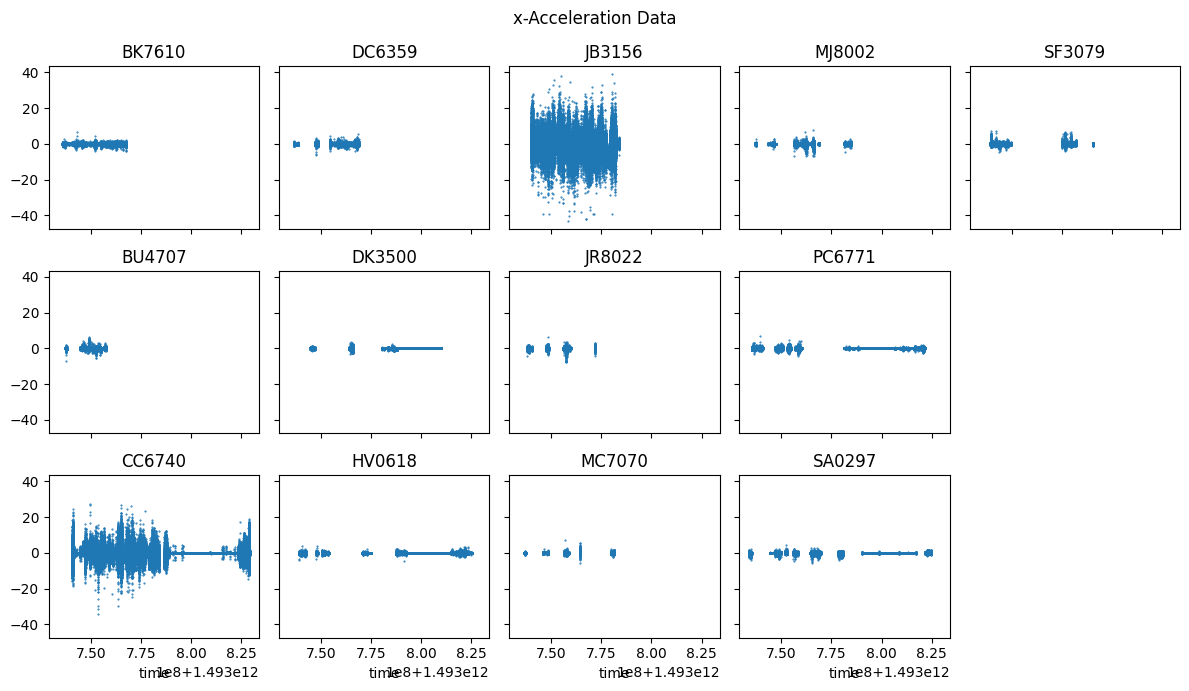

In [11]:
fig, ax = plt.subplots(3,5, figsize=(12,7), sharex=True, sharey = True)

direction = 'x';

for k, pid in enumerate(pid_list):
    acc_df[pid].iloc[1:-1].plot(x='time', y = direction, marker = '.', markersize = 1, linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))], legend=False)
    ax[k%3, int(np.floor(k/3))].set_title(pid)
    
fig.suptitle(f'{direction}-Acceleration Data')
fig.delaxes(ax[1,4])
fig.delaxes(ax[2,4])
plt.tight_layout()
plt.show()

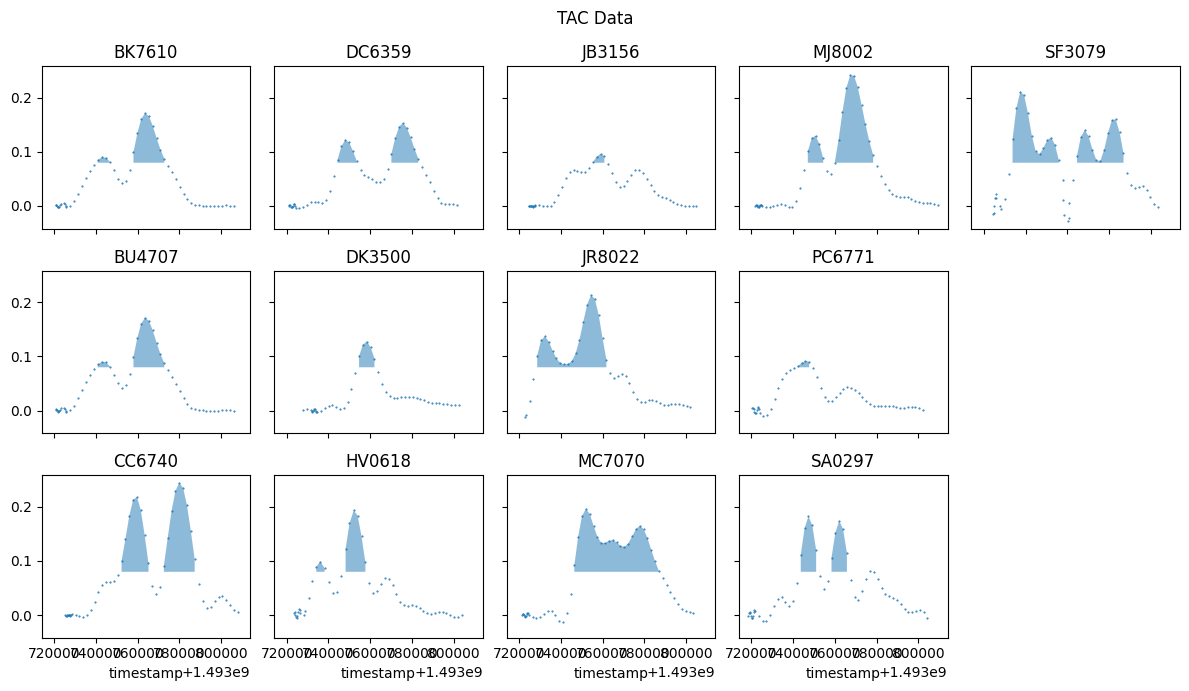

In [14]:
fig, ax = plt.subplots(3,5, figsize=(12,7), sharey=True, sharex=True)


for k, pid in enumerate(pid_list):
    df = tac_df[pid].iloc[1:-1]
    i,j = k%3, int(np.floor(k/3))
    df.plot(x='timestamp', y = 'TAC_Reading', marker = '.', markersize=1, linestyle = 'none', ax = ax[i,j], legend=False)
    ax[i,j].fill_between(df['timestamp'], TAC_limit, df['TAC_Reading'], where = df['TAC_Reading']>=TAC_limit, alpha=0.5)
    ax[i,j].set_title(pid)
    
fig.suptitle('TAC Data')
fig.delaxes(ax[1,4])
fig.delaxes(ax[2,4])
plt.tight_layout()
plt.show()

## Observations

 - every subject has patches of missing data
 - subjects JB3156 and CC6740 accelerometer data looks categorically different; coincidentally, both subjects use Android phones. For now, I'll restrict the analysis to iPhone data.
 - TAC data looks okay

# Clean Up Data

 - Remove unusable subject data
 - Convert accelerometer time to seconds and resample TAC to align with accelerometer timestamps
 - Snip out 8 sec clips. Why 8 sec? We're attempting to infer blood alcohol levels from accelerations induced by the subjects' movement patterns. If the acceleration data encodes bouts of walking, a rhythmic behavior, the frequency content of acceleration signals could be useful. Typically, h Most notably,  though we may also find accelerations suggesting the subject has fallen or dropped their phone.



In [15]:
pid_remove = ['JB3156', 'CC6740']

for pid in pid_remove:
    if pid in pid_list:
        pid_list.remove(pid)
    acc_df.pop(pid, None)
    tac_df.pop(pid, None)

In [16]:
for pid in pid_list:
    try:
        tac_df[pid].rename(columns={'timestamp':'time_s'}, inplace=True)
        acc_df[pid]['time_s'] = acc_df[pid]['time'].to_numpy()/1000
        del acc_df[pid]['time']
    except:
        print('already been done')
    
    linear_interp = interp1d(tac_df[pid]['time_s'].to_numpy(), tac_df[pid]['TAC_Reading'], kind='linear', axis=0, bounds_error=False)
    acc_df[pid]['tac'] = linear_interp(acc_df[pid]['time_s'].to_numpy())
    
    acc_df[pid].dropna(axis=0, how = 'any', inplace=True)   # tac readings extend past accelerometer readings, so trim down where extrapolation gives Null tac values
    
    tac_df[pid]['time_s'] = tac_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]
    acc_df[pid]['time_s'] = acc_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]


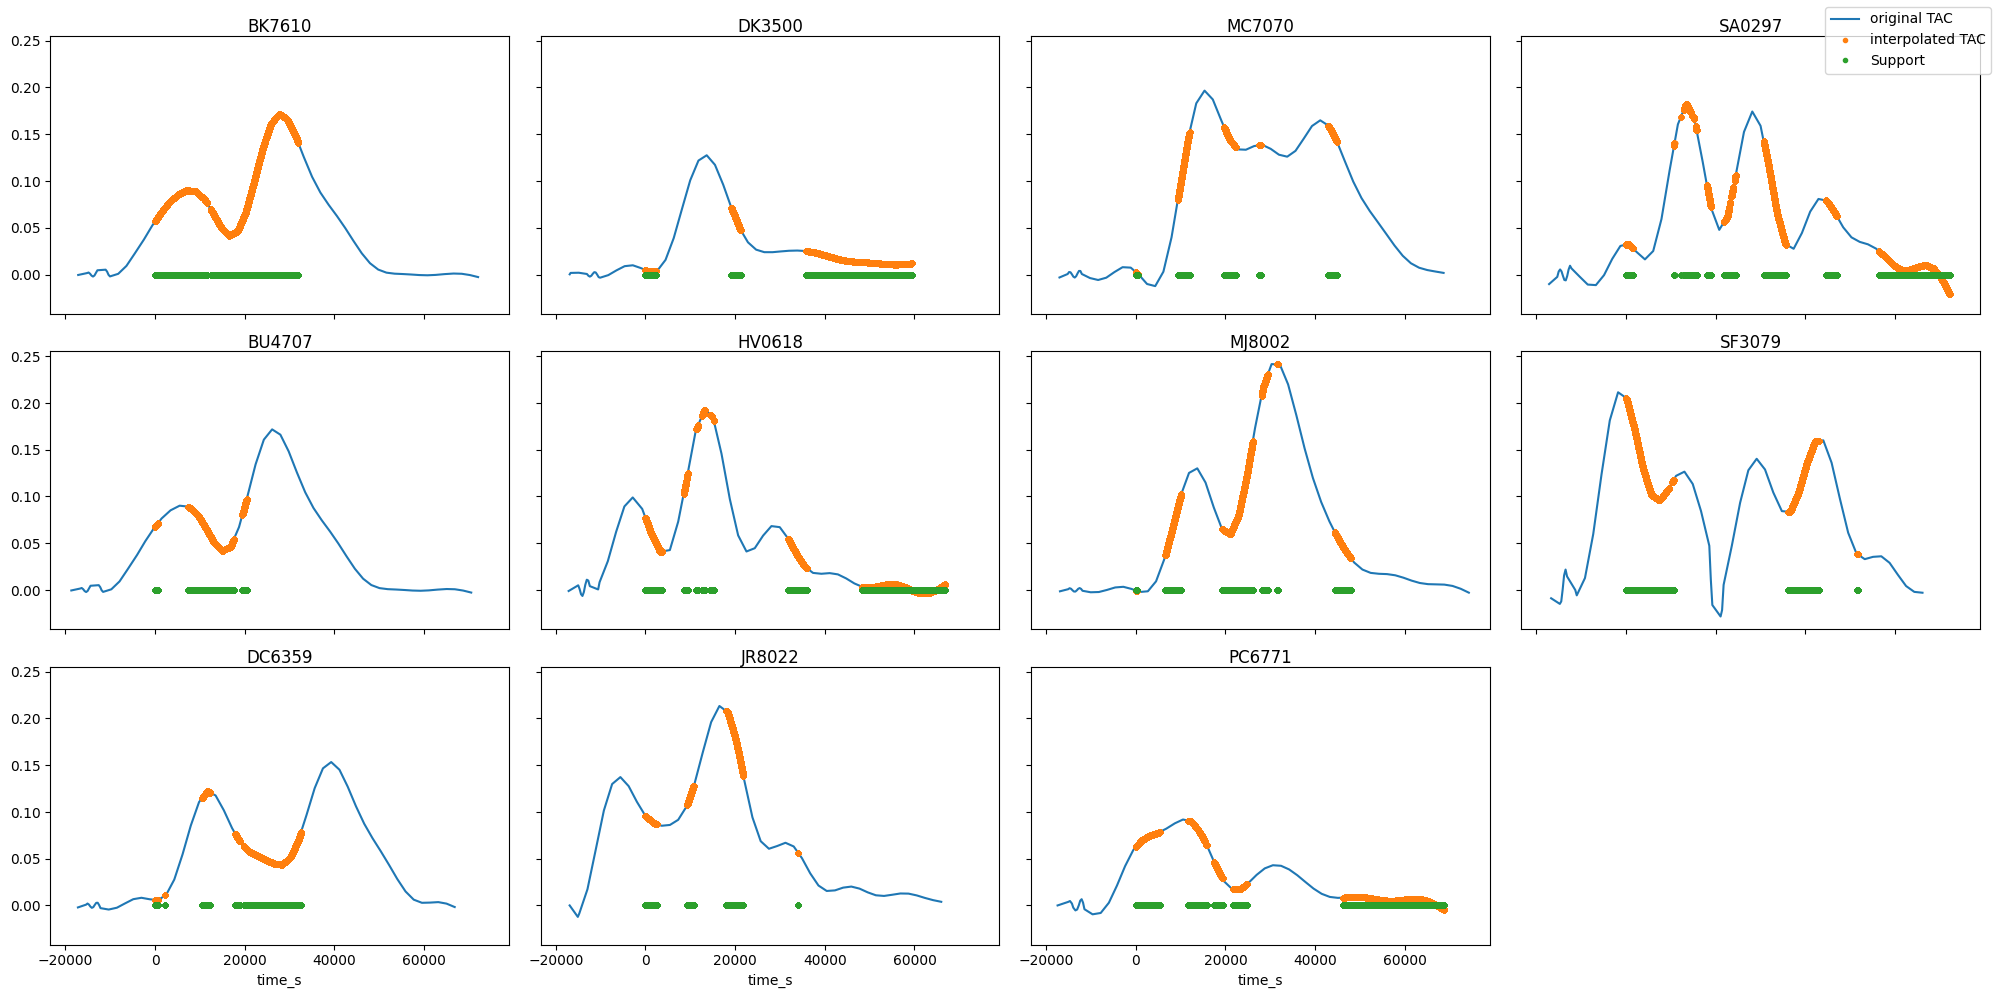

In [17]:
fig, ax = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)

for k, pid in enumerate(pid_list):
    i,j = k%3, int(np.floor(k/3))
    tac_df[pid].plot(x='time_s', y = 'TAC_Reading', ax = ax[i,j], \
                                     legend=False)
    acc_df[pid].plot(x='time_s', y = 'tac', ax = ax[i,j], \
                                     marker = '.', linestyle = 'none',\
                                     legend=False)
    ax[i,j].plot(acc_df[pid].time_s, np.zeros(len(acc_df[pid].time_s)), \
                                                    marker = '.', linestyle = 'none')
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)

lines = ax[0,0].get_lines()
labels = ['original TAC', 'interpolated TAC', 'Support']
fig.legend(lines, labels)

fig.delaxes(ax[2,3])
plt.tight_layout()
plt.show()

Explain windowing. overlap = 0.5

<a id='transform'></a>
# Transforming Data

Glossary:

pid
sid
x,y,z
rho, theta, phi

fftx,ffty,fftz
fftr,fftt,fftp



In [18]:
# Cartesian Accelerations and their ICA signals
xyz = ['x', 'y', 'z']
#C = ['C1', 'C2', 'C3']
C = ['C1', 'C2']

# Spherical Accelerations and their ICA signals
rtp = ['rho', 'theta', 'phi']
#S = ['S1', 'S2', 'S3']
S = ['S1', 'S2']

#ica = FastICA(n_components=2, algorithm = 'parallel', whiten = 'arbitrary-variance', tol=1e-3, max_iter=500)
pca = PCA(n_components=2)

In [ ]:
win_sec = 10  # sliding window in seconds
win = win_sec * 40   # sliding window size in number of samples

win_14 = int(win/4)
win_12 = int(win/2)
win_34 = int(3*win/4)

win_slide = win_34


subject_data = {}

for pid in pid_list:
    print(f"{pid}...")
    
    acc_df[pid].dropna(axis=0, how = 'any')
    gap_idx = np.argwhere([np.diff(acc_df[pid].time_s)>0.25])[:,1]
    gap_idx = np.append(np.array([0]), gap_idx)

    gap_pairs = np.vstack((gap_idx[0:-2], gap_idx[1:-1])).transpose()
    gap_sizes = np.squeeze(np.diff(gap_pairs, axis=1))
    
    sample = []
    sample_fft = []
    sample_count = 0
    
    for k, gap in tqdm(enumerate(gap_sizes)):
        if gap>win:
            start_idx = int(((gap%(win_34))/2) + gap_idx[k])
            while (start_idx + win) < gap_pairs[k, 1]:
                s = acc_df[pid].iloc[start_idx:(start_idx+win)].reset_index().drop(columns='index')
                s = s.assign(sid=sample_count)
                
                s[rtp] = cart_to_spherical(s[xyz].to_numpy())
                # mmm = np.linalg.norm(s[xyz].to_numpy(), axis = 1)
                # s['rho'] = np.linalg.norm(s[xyz].to_numpy(), axis = 1)   # Just using rho, vector magnitude
                
                s[C] = pca.fit_transform(s[xyz].to_numpy())
                s[S] = pca.fit_transform(s[rtp].to_numpy())
                
                sf = s[['pid', 'sid']].iloc[0:win_14]
                
                sf['freq'] = np.fft.fftfreq(win, 0.025)[0:win_14]
                sf[xyz] = np.abs(np.fft.fft(s[xyz].to_numpy(), axis=0))[0:win_14,:]
                sf[rtp] = np.abs(np.fft.fft(s[rtp].to_numpy(), axis=0))[0:win_14,:]
                
                sf[C] = np.abs(np.fft.fft(s[C].to_numpy(), axis=0))[0:win_14,:]
                sf[S] = np.abs(np.fft.fft(s[S].to_numpy(), axis=0))[0:win_14,:]
                
                sample_count+=1
                
                sample.append(s[['pid', 'sid', 'tac', 'time_s'] + xyz + C + rtp + S])
                sample_fft.append(sf[['pid', 'sid', 'freq'] + xyz + C + rtp + S])
                
                start_idx += win_slide
    
    sample_df = pd.concat(sample).reset_index()
    sample_df.drop(columns = 'index', inplace=True)
    
    sample_fft_df = pd.concat(sample_fft).reset_index()
    sample_fft_df.drop(columns = 'index', inplace=True)

    subject_data[pid] = {'sample':sample_df, 'sample_fft':sample_fft_df}

print('...done.')

pickle.dump(subject_data, open("subject_data.p","wb"))

In [45]:
subject_data[pid]['sample_fft'].head()

,pid,sid,freq,x,y,z,C1,C2,rho,theta,phi,S1,S2
0,SF3079,0,0.0,0.442816,3.031200,3.411700,2.088277e-07,2.434354e-08,6.206577,2226.509942,375.563857,0.000088,0.000025
1,SF3079,0,0.1,0.035775,0.057733,0.101979,1.030200e-01,5.400591e-02,0.725725,866.061549,9.050836,865.972660,15.356176
2,SF3079,0,0.2,0.057640,0.149962,0.238748,2.287505e-01,1.495078e-01,0.902992,348.033105,28.727560,348.630997,20.229374
3,SF3079,0,0.3,0.031889,0.025758,0.155027,1.518685e-01,5.126487e-02,0.895177,372.789090,19.913091,373.183832,10.130082
4,SF3079,0,0.4,0.057321,0.041797,0.206780,2.106219e-01,3.798726e-02,0.503636,268.599000,20.008588,268.930363,14.912981


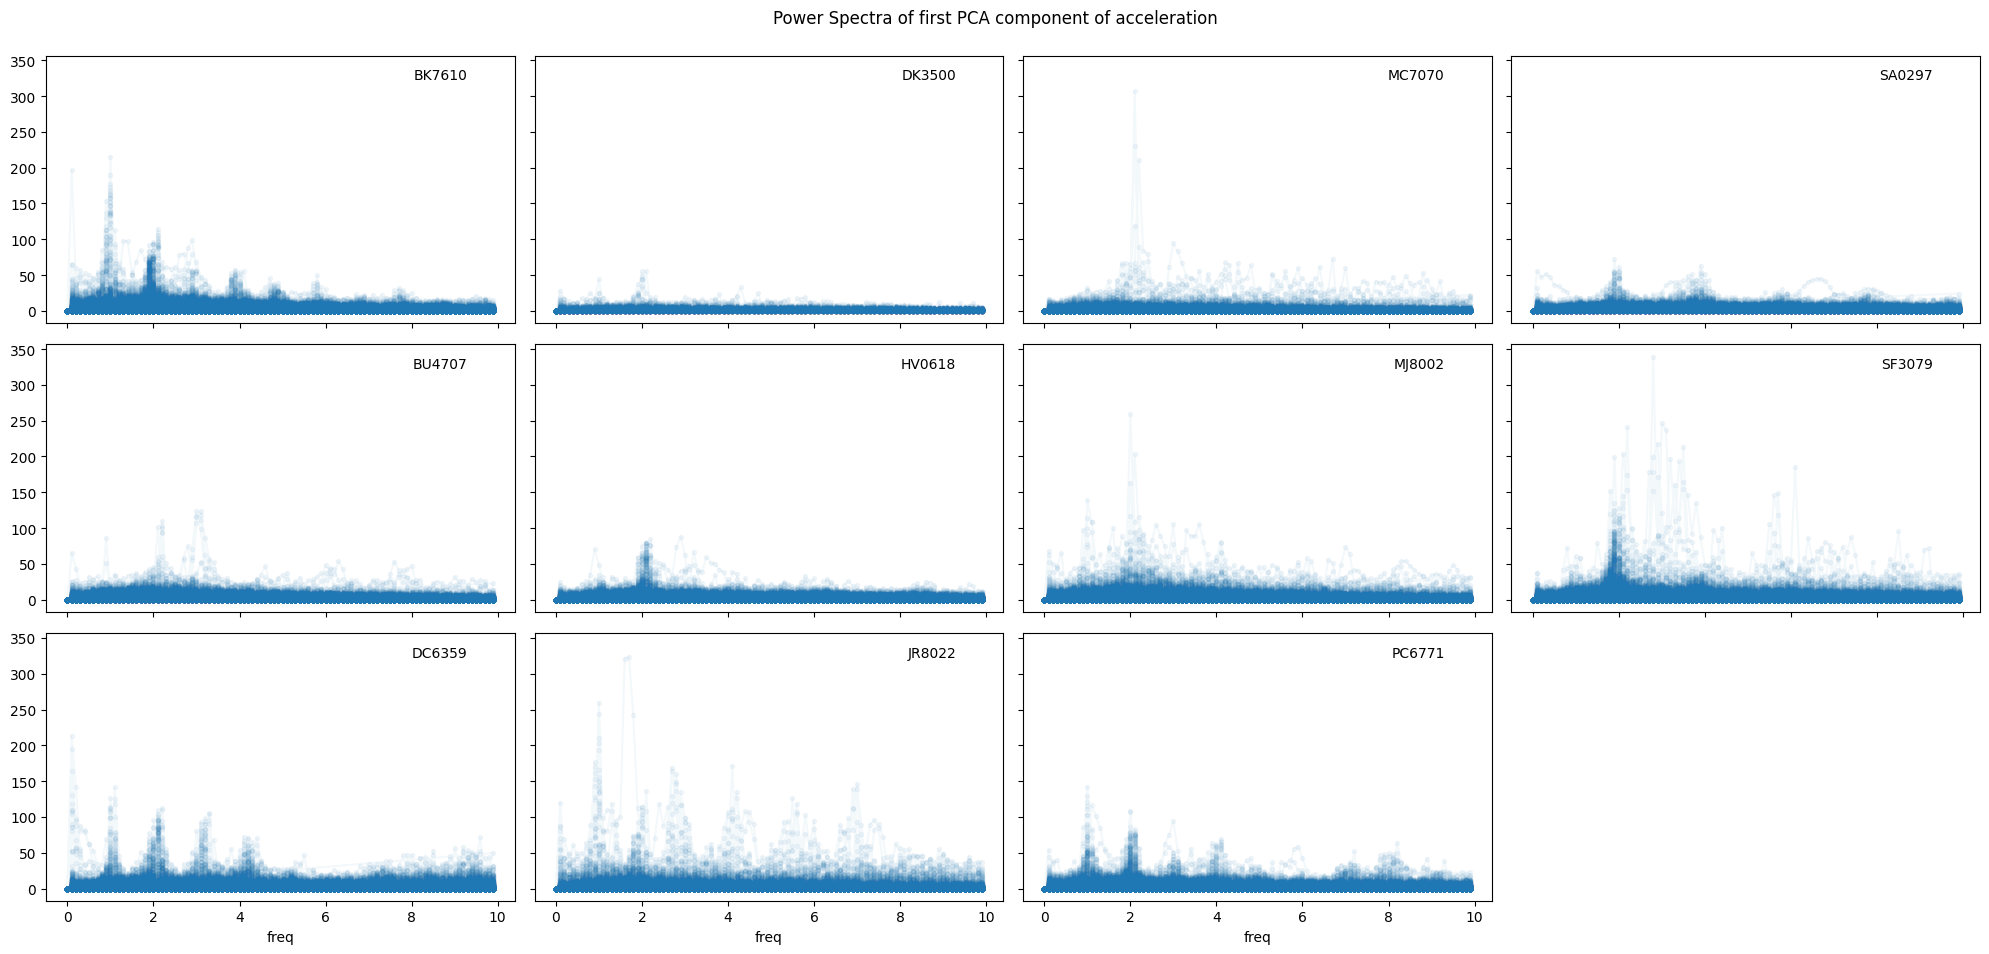

In [88]:
fig, ax = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)

for k, pid in enumerate(pid_list):
    i,j = k%3, int(np.floor(k/3))
    df = subject_data[pid]['sample_fft']

    df.plot(x='freq', y = ['C1'], 
        marker = '.', linestyle = None, alpha = 0.05, 
        ax = ax[i,j], legend=False)
    
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)
    
fig.delaxes(ax[2,3])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Power Spectra of first PCA component of acceleration')
plt.show()

## Observations

The spectra of the first principle component look sensible. Most of the time, subjects aren't moving much, hence a dense band across the bottom of the spectrum (low-power white spectrum) with peaks corresponding to activity.

 - Subjects show peaks at around 2 Hz, which is nominal walking frequency.
 - That the peaks around 2 Hz are blurred (not sharp) suggests variable walking frequency. The harmonics (peaks at multiples of 2 Hz) define the "shape" of the walking gait.
 - Peaks below 2 Hz are some other slow oscillatory movement.

<a id='features'></a>
# Statistics, normalization, and feature creation



In [19]:
from BarCrawl_helpers import *

import numpy as np
import pandas as pd

import re as re
from tqdm import tqdm

import sys
import warnings

warnings.filterwarnings('ignore')

In [22]:
if exists('subject_data.p') and USE_SAVED:
    subject_data =pickle.load(open("subject_data.p","rb"))
    
pid_list = list(subject_data.keys())

pid0 = pid_list[0]

In [23]:
subject_data[pid0]['sample'].head()

,pid,sid,tac,time_s,x,y,z,C1,C2,rho,theta,phi,S1,S2
0,BK7610,0,0.056953,2.451,-0.004002,0.0052,0.0010,-0.007883,0.003459,0.006637,2.226662,1.419537,53.152622,0.029924
1,BK7610,0,0.056954,2.476,-0.000500,0.0302,0.0227,0.002352,-0.028041,0.037783,1.587354,0.926298,52.513302,-0.463420
2,BK7610,0,0.056954,2.500,-0.009102,0.0300,0.0420,0.021428,-0.033232,0.052410,1.865361,0.641213,52.791313,-0.748561
3,BK7610,0,0.056954,2.527,-0.018997,-0.0031,0.0049,0.000973,0.013144,0.019862,3.303344,1.321519,54.229298,-0.068150
4,BK7610,0,0.056954,2.551,-0.016693,-0.0209,-0.0183,-0.014145,0.037377,0.032409,4.038433,2.170805,54.964397,0.781079


In [24]:
subject_data[pid0]['sample_fft'].head()
# stats_fft_temp = subject_data[pid]['sample_fft'].drop(columns='freq').groupby(['pid', 'sid']).agg([power, dc, peak, peak_freq])

,pid,sid,freq,x,y,z,C1,C2,rho,theta,phi,S1,S2
0,BK7610,0,0.0,0.378693,1.490600,3.918900,3.325113e-08,2.854231e-07,22.043338,20370.383392,555.755966,0.000844,0.000033
1,BK7610,0,0.1,0.800844,0.361167,1.319130,1.319580e+00,2.885166e-01,2.160941,5761.442678,14.831388,5761.442603,14.847070
2,BK7610,0,0.2,1.028118,0.194124,1.900259,1.723881e+00,8.110972e-01,7.182344,2793.766444,6.572983,2793.767203,6.613408
3,BK7610,0,0.3,1.771755,0.063159,1.914804,1.951763e+00,5.754892e-01,2.679532,2055.167258,24.323244,2055.167431,24.309304
4,BK7610,0,0.4,1.190414,0.189216,2.313085,2.183559e+00,9.284566e-01,3.242622,1081.244810,19.618106,1081.244380,19.614105


In [27]:
subject_stats = {}

for pid in tqdm(pid_list):
    print(pid)
    
    stats_temp = subject_data[pid]['sample'].groupby(['sid']).agg(['mean', 'std', 'max', 'min'])

    # stats_temp = subject_data[pid]['sample'].drop(columns = 'time_s').groupby(['sid']).agg(['mean', 'std', 'max', 'min'])
    # stats_temp.drop(columns = ['tac_min', 'tac_mean', 'tac_std', 'time_s_min', 'time_s_max', 'time_s_std'], inplace=True, errors = 'ignore')
    # stats_temp.rename(columns = {'tac_max':'tac'}, inplace=True)
    # stats_temp.rename(columns = {'time_s_mean':'time_s'}, inplace=True)
    
    # stats_fft_temp = subject_data[pid]['sample_fft'].drop(columns='freq').groupby(['pid', 'sid']).agg([power, dc, peak, peak_freq])
    stats_fft_temp = subject_data[pid]['sample_fft'].drop(columns='freq').groupby(['sid']).agg([power, peak, peak_freq])

    
    # join time-domain and frequency-domain stats
    subject_stats[pid] = stats_temp.join(stats_fft_temp)
    
    
    # combine the multi-index column names into single string
    col_names = subject_stats[pid].columns.to_flat_index().values
    subject_stats[pid].columns = ['_'.join(col_name) for col_name in col_names]
    
    subject_stats[pid].drop(columns = ['tac_min', 'tac_mean', 'tac_std', 'time_s_mean', 'time_s_max', 'time_s_std'], inplace=True, errors = 'ignore')
    subject_stats[pid].rename(columns = {'tac_max':'tac'}, inplace=True)
    subject_stats[pid].rename(columns = {'time_s_min':'time_s'}, inplace=True)

    
print('...done.')

  0%|          | 0/11 [00:00<?, ?it/s]

BK7610


  9%|▉         | 1/11 [00:11<01:51, 11.17s/it]

BU4707


 18%|█▊        | 2/11 [00:15<01:06,  7.42s/it]

DC6359


 27%|██▋       | 3/11 [00:22<00:54,  6.81s/it]

DK3500


 36%|███▋      | 4/11 [00:23<00:31,  4.53s/it]

HV0618


 45%|████▌     | 5/11 [00:27<00:27,  4.62s/it]

JR8022


 55%|█████▍    | 6/11 [00:31<00:20,  4.14s/it]

MC7070


 64%|██████▎   | 7/11 [00:33<00:14,  3.72s/it]

MJ8002


 73%|███████▎  | 8/11 [00:39<00:13,  4.37s/it]

PC6771


 82%|████████▏ | 9/11 [00:46<00:09,  5.00s/it]

SA0297


 91%|█████████ | 10/11 [00:48<00:04,  4.36s/it]

SF3079


100%|██████████| 11/11 [00:56<00:00,  5.16s/it]

...done.


In [42]:
# Check that the data are unique across subjects and within subjects

# for pid in pid_list:
#     print(f'\n{pid}')
#     display(subject_stats[pid].head(2))
#     display(subject_stats[pid].tail(2))

## Features, Targets, and Annotation

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [36]:
targets = {}
features = {}
anno = {}

for pid in pid_list:
    targets[pid] = pd.DataFrame({'tac':subject_stats[pid]['tac'],
                                'isOverLimit': 1.0*(subject_stats[pid]['tac']>TAC_limit)})
    
    features[pid] = subject_stats[pid].drop(columns=['time_s','tac'])

    anno[pid] = subject_stats[pid]['time_s']

In [41]:
display(features[pid].head(2))
display(targets[pid].head(2))
display(anno[pid].head(2))

,x_mean,x_std,x_max,x_min,y_mean,y_std,y_max,y_min,z_mean,z_std,...,theta_peak_freq,phi_power,phi_peak,phi_peak_freq,S1_power,S1_peak,S1_peak_freq,S2_power,S2_peak,S2_peak_freq
sid,,,,,,,,,,,,,,,,,,,,,
0,0.001107,0.006463,0.045197,-0.02150,0.007578,0.005951,0.0485,-0.0487,0.008529,0.013243,...,0.1,398.947397,34.638422,7.6,1114.879915,865.972660,0.1,131.412215,34.725815,7.6
1,0.001077,0.006850,0.024597,-0.03479,0.006720,0.007251,0.0762,-0.0314,0.007673,0.009348,...,0.2,444.165485,43.691007,7.8,1047.400207,586.254993,0.2,155.187034,43.485883,7.8


,tac,isOverLimit
sid,,
0,0.205426,1.0
1,0.205400,1.0


sid
0    2.446
1    9.961
Name: time_s, dtype: float64

In [10]:
scaler = StandardScaler()
cols = features[pid].columns

for pid in pid_list:
    data_scaled = scaler.fit_transform(features[pid])
    features[pid] = pd.DataFrame(data_scaled, columns = cols)

In [11]:
features_df = pd.concat(features)
targets_df = pd.concat(targets)

pickle.dump((features_df, targets_df), open("features_targets.p","wb"))

## Modeling and Assessment

Using the feature and target data above to train classifiers, I'll be fitting and comparing the following classifiers:

 - Random Forest
 - Boosted Random Forest (XGBoost)
 - Neural Networks

 <a id='model'></a>


In [154]:
import pandas as pd
import re

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn import metrics
from sklearn_evaluation import plot

import pickle
from os.path import exists

if exists('features_targets.p'):
    features_df, targets_df = pickle.load(open("features_targets.p", "rb"))

In [158]:
frac = lambda x: sum(x)/len(x)

X = features_df.to_numpy()
y = targets_df['isOverLimit'].to_numpy()

kfcv = StratifiedKFold(n_splits = 5, random_state = 3, shuffle = True)

scoring = ['accuracy', 'recall', 'precision', 'f1']


print('Fraction of training and testing samples that are positives (TAC over the limit):\n')

for train_idx, test_idx in kfcv.split(X,y):
    y_train, y_test = y[train_idx], y[test_idx]
    print(f'Training: {frac(y_train)} \tTesting:{frac(y_test)}\tCheck Sum:{sum(y_train)+sum(y_test)}')

print(f'\nFraction of positives in full set: {frac(y)} \tCheck Sum: {sum(y)}')


Fraction of training and testing samples that are positives (TAC over the limit):

Training: 0.47319530819491457 	Testing:0.4729219143576826	Check Sum:7513.0
Training: 0.4731165866330788 	Testing:0.4732367758186398	Check Sum:7513.0
Training: 0.4731165866330788 	Testing:0.4732367758186398	Check Sum:7513.0
Training: 0.4731165866330788 	Testing:0.4732367758186398	Check Sum:7513.0
Training: 0.47315806045340053 	Testing:0.47307086614173227	Check Sum:7513.0

Fraction of positives in full set: 0.473140625984004 	Check Sum: 7513.0


The distribution of positive cases in the training/testing sets is relatively uniform and consistent with the fraction of positive cases in the full data set.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# frac = lambda x: sum(x)/len(x)
# test_frac = frac(y_train)
# train_frac = frac(y_test)
# total = sum(y_train) + sum(y_test)

# print(f"""Fraction of training and testing sets that are positives (TAC over the limit): 
# train:\t{train_frac}
# test:\t{test_frac}

# Total positives: {total}
# (this number should not change regardless of split)""")

### Random Forest Classifier

In [148]:
rafo_params = {
    'n_estimators':[200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20]
 }

rafo_classifier = GridSearchCV(estimator = RandomForestClassifier(), 
    param_grid = rafo_params, cv = kfcv,
    refit = 'f1', scoring = scoring, 
    n_jobs = -1)

rafo_classifier.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20], 'n_estimators': [200, 400]},
             refit='f1', scoring=['accuracy', 'recall', 'precision', 'f1'])

In [149]:
rafo_best = rafo_classifier.best_estimator_
rafo_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, n_estimators=400)

In [150]:
y_pred = rafo_best.predict(X_test)>0.5

rafo_results = metrics.classification_report(y_test, y_pred)

print(rafo_results)

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      1644
         1.0       0.85      0.84      0.84      1532

    accuracy                           0.85      3176
   macro avg       0.85      0.85      0.85      3176
weighted avg       0.85      0.85      0.85      3176



### Boosted Decision Trees (XGBoost)

In [20]:
from xgboost import XGBClassifier

xgb_params = {
    'objective': ['binary:logistic', 'binary:hinge'],
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 20],
    'learning_rate':[0.1, 0.05, 0.025]
}

xgb_classifier = GridSearchCV(estimator = XGBClassifier(),
    param_grid=xgb_params, cv = kfcv,
    refit = 'f1', scoring = scoring,
    n_jobs=-1)

xgb_classifier.fit(X,y)



GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.025],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [100, 200, 400],
                         'objective': ['binary:logistic', 'binary:hinge']},
             refit='f1', scoring=['accuracy', 'recall', 'precision', 'f1'])

In [151]:
xgb_best = xgb_classifier.best_estimator_
xgb_best.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=20, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [152]:
y_pred = xgb_best.predict(X_test)>0.5

xgb_results = metrics.classification_report(y_test, y_pred)

print(xgb_results)

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      1644
         1.0       0.85      0.86      0.86      1532

    accuracy                           0.86      3176
   macro avg       0.86      0.86      0.86      3176
weighted avg       0.86      0.86      0.86      3176



array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

### Neural Network

In [135]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras.regularizers as regularizers


In [97]:
X_train.shape

(12703, 70)

In [140]:
num_inputs = X_train.shape[1]

input = Input(shape=(num_inputs,))
lay1 = Dense(units = 200, activation = 'relu')(input)
lay2 = Dense(units = 200, activation = 'relu')(input)
# lay2 = Dense(units = 50, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(lay1)
output = Dense(units = 1, activation = 'sigmoid')(lay1)

nn_classifier = Model(input,output)

nn_classifier.compile(optimizer='adam', loss='binary_crossentropy')
nn_classifier.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose = 2)

Epoch 1/1000
397/397 - 1s - loss: 0.6511 - val_loss: 0.6401 - 806ms/epoch - 2ms/step
Epoch 2/1000
397/397 - 0s - loss: 0.6078 - val_loss: 0.6282 - 322ms/epoch - 811us/step
Epoch 3/1000
397/397 - 0s - loss: 0.5897 - val_loss: 0.5925 - 310ms/epoch - 782us/step
Epoch 4/1000
397/397 - 0s - loss: 0.5687 - val_loss: 0.5801 - 308ms/epoch - 775us/step
Epoch 5/1000
397/397 - 0s - loss: 0.5522 - val_loss: 0.5737 - 311ms/epoch - 784us/step
Epoch 6/1000
397/397 - 0s - loss: 0.5372 - val_loss: 0.5651 - 309ms/epoch - 778us/step
Epoch 7/1000
397/397 - 0s - loss: 0.5233 - val_loss: 0.5861 - 315ms/epoch - 793us/step
Epoch 8/1000
397/397 - 0s - loss: 0.5178 - val_loss: 0.5624 - 314ms/epoch - 791us/step
Epoch 9/1000
397/397 - 0s - loss: 0.5009 - val_loss: 0.5489 - 310ms/epoch - 780us/step
Epoch 10/1000
397/397 - 0s - loss: 0.4938 - val_loss: 0.5406 - 311ms/epoch - 782us/step
Epoch 11/1000
397/397 - 0s - loss: 0.4868 - val_loss: 0.5623 - 311ms/epoch - 784us/step
Epoch 12/1000
397/397 - 0s - loss: 0.4733 -

In [141]:
# nn_results = cross_validate(nn_classifier, X, y, cv=kfcv, scoring=scoring)
y_pred = nn_classifier.predict(X_test)>0.5

nn_results = metrics.classification_report(y_test, y_pred)

print(nn_results)

100/100 [==============================] - 0s 544us/step
              precision    recall  f1-score   support

         0.0       0.75      0.74      0.74      1644
         1.0       0.72      0.74      0.73      1532

    accuracy                           0.74      3176
   macro avg       0.74      0.74      0.74      3176
weighted avg       0.74      0.74      0.74      3176



In [117]:
y_pred[0:10]

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [118]:
rafo_classifier = RandomForestClassifier()
rafo_classifier.fit(X_train, y_train)

KeyboardInterrupt: 

In [7]:
y_pred = rafo_classifier.predict(X_test)

In [8]:
f1_score = metrics.f1_score(y_test, y_pred)
recall_score = metrics.recall_score(y_test, y_pred)
prec_score = metrics.precision_score(y_test, y_pred)

print(f'F1: {f1_score}\tRecall: {recall_score}\tPrecision:{prec_score}')
fi = rafo_classifier.feature_importances_

idx = np.argsort(-1*fi)

for i in idx:
    print(f'Feature {cols[i]}: {fi[i]}')
    

F1: 0.8349982776438168	Recall: 0.8128772635814889	Precision:0.8583569405099151


NameError: name 'cols' is not defined

In [185]:
PCcols = [c for c in features_df.columns if not (c.startswith('S') or c.startswith('C'))]
PCcols = [c for c in features_df.columns if (re.fullmatch(r'[Cxyz].*',c))]
print(PCcols)
#PCcols = features_df.columns[:]

Xc = features_df[PCcols].to_numpy()
Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size=0.2)

['x_mean', 'x_std', 'x_max', 'x_min', 'y_mean', 'y_std', 'y_max', 'y_min', 'z_mean', 'z_std', 'z_max', 'z_min', 'C1_mean', 'C1_std', 'C1_max', 'C1_min', 'C2_mean', 'C2_std', 'C2_max', 'C2_min', 'x_power', 'x_peak', 'x_peak_freq', 'y_power', 'y_peak', 'y_peak_freq', 'z_power', 'z_peak', 'z_peak_freq', 'C1_power', 'C1_peak', 'C1_peak_freq', 'C2_power', 'C2_peak', 'C2_peak_freq']


In [186]:
rafo_classifier.fit(Xc_train, y_train)
yc_pred = rafo_classifier.predict(Xc_test)

In [56]:
display(metrics.f1_score(y_test, yc_pred))

fi = rafo_classifier.feature_importances_

idx = np.argsort(-1*fi)

for i in idx:
    print(f'Feature {PCcols[i]}: {fi[i]}')

NameError: name 'yc_pred' is not defined

In [ ]:
stats = []
stats_fft = []

for s,sf in zip(sample, sample_fft):
    s_temp = s.drop(columns = 'time_s').groupby(['pid', 'sid']).agg(['mean', 'std', 'max', 'min'])
    s_temp.drop(columns = ['tac_min', 'tac_mean', 'tac_std'], inplace=True, errors = 'ignore')
    s_temp.rename(columns = {'tac_max':'tac'}, inplace=True)
    
    stats.append(s_temp)
    
    sf_temp = sf.drop(columns='freq').groupby(['pid', 'sid']).agg([power, dc, peak, peak_freq])
    stats_fft.append(sf_temp)

In [ ]:
sample_df.head()

In [ ]:
null_count(sample_fft_df)

In [ ]:
stats_df = sample_df[sample_df['pid']==pid].groupby(['pid', 'sid']).agg(['mean', 'std', 'max','min'])

In [ ]:
stats_df.plot(x = ('time_s', 'mean'), y=('tac','mean'), marker = '.')

In [ ]:
len(sample_df)/len(stats_df)

In [ ]:
stats_df.columns = ['_'.join(col_names) for col_names in stats_df.columns.to_flat_index().values]

In [ ]:
stats_df.head()

In [ ]:
stats_df.drop(columns = ['tac_min', 'tac_mean', 'tac_std'], inplace=True, errors = 'ignore')
stats_df.rename(columns = {'tac_max':'tac'}, inplace=True)
stats_df['tac_over_limit'] = stats_df['tac'].to_numpy()>=0.08
stats_df.head()

In [ ]:
stats_fft_df = sample_fft_df[sample_fft_df['pid']=='BK7610'].drop(columns='freq').groupby(['pid', 'sid']).agg([power, dc, peak, peak_freq])
stats_fft_df.head()

In [ ]:
stats_fft_df.columns = ['_'.join(col_names) for col_names in stats_fft_df.columns.to_flat_index().values]

In [ ]:
stats_fft_df.head()

In [ ]:
features_df = stats_df.join(stats_fft_df, on = ['pid','sid'])
features_df.columns

In [ ]:
features_df['tac'].hist(bins=100)

In [ ]:
null_count(features_df)

In [ ]:
features_df.groupby('tac_over_limit')['tac'].count()

# Modeling, Validation, and Model Selection

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
targets_df = features_df.tac

In [ ]:
for col in features_df.columns:
    print(f"{col}: {features_df[col].isna().sum()}")

## Summary

# Sandbox below

In [ ]:
np.abs(sample[1].fftx.to_numpy())[0:50]

In [ ]:
# fftx = 
# # for s in tqdm(sample):
# #     fftx
#sample_fft[1200].plot(x = 'freq', y = ['x', 'y', 'z', 'C1', 'C2'])
sample_fft_df[sample_fft_df['pid'] == 'BK7610'].plot(x = 'freq', y = 'C2', marker = '.', linestyle= 'none', alpha = 0.1)

plt.xlim([-0.1, 5])

In [ ]:
# win_sec = 10  # sliding window in seconds
# win = win_sec * 40   # sliding window size in number of samples
# win_34 = int(3*win/4)

# sample_df = pd.DataFrame()
# for pid in pid_list:
#     gap_idx = np.argwhere([np.diff(acc_df[pid].time_s)>0.25])[:,1]
#     gap_idx = np.append(np.array([0]), gap_idx)

#     gap_pairs = np.vstack((gap_idx[0:-2], gap_idx[1:-1])).transpose()
#     gap_sizes = np.squeeze(np.diff(gap_pairs, axis=1))
#     for k, gap in enumerate(gap_sizes):
#         if gap>win:
#             start_idx = int(((gap%(win_34))/2) + gap_idx[k])
#             while (start_idx + win) < gap_pairs[k, 1]:
#                 s = acc_df[pid].iloc[start_idx:(start_idx+win)].reset_index().drop(columns='index')
#                 s = s.assign(sid=k)
#                 sample_df = pd.concat([sample_df, s])
#                 start_idx += win_34  

In [ ]:
test_df = sample[1].copy()
# test_df[['rho', 'theta', 'phi']] = test_df[['x', 'y', 'z']].apply(cart_to_spherical, axis=1, result_type='expand')
# test_df[['x', 'y', 'z']].apply(cart_to_spherical, axis=1, result_type='expand')

test_df[['rho', 'theta', 'phi']] = cart_to_spherical(test_df[['x', 'y', 'z']].to_numpy())

# r, t, p = cart_to_spherical(xyz)
test_df

In [ ]:
sample[1][['x','y','z']].agg(['mean', 'std', q25, q50, q75])

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20, 2))
plt.plot(acc_df[pid].time, np.ones(np.size(acc_df[pid].time)), '.')
plt.plot(acc_df[pid]['time'].iloc[gap_idx], np.ones(len(gap_idx)), '.')

#plt.plot(np.diff(acc_df[pid].time))
print(pid)

In [ ]:
type(sample)

In [ ]:
stats = ['mean', 'std', 'max', q75, q50, q25, 'min']
sample_grouped = sample[1][['x','y','z']].agg(stats).stack().to_frame().transpose()

sample_grouped

In [ ]:
data = []
for k in range(5):
    data.append([np.random.random((1,5))])
    
AA = pd.DataFrame(data, columns=['b'])


AA.head()
# for k in range(10):
#     AA['b'].loc[k] = [np.random.random((5,3))]


In [ ]:
5 in [5, 10, 15]

In [ ]:
AA['b'].to_numpy().mean(axis=0)

In [ ]:
data.mean(axis=0)

In [ ]:
AA = pd.DataFrame({'a':[15 ,18, 11, 7], 'b':[21, 19, 20, 2]})

In [ ]:
AA.head()

In [ ]:
AA.agg([lambda x: np.linalg.norm(x, axis=0)])

In [ ]:
AA.iloc[1:].agg('idxmax')

In [ ]:
xx = np.array([3, 4])
np.argmax(xx)